First, load the packages

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report


#models
from sklearn.svm import SVC



import re

import spacy
import pandas as pd
import itertools as it 

nlp = spacy.load('en')


### Load functions

In [2]:
#import data
def importdf_sample_magnitude(order_of_magnitude=None, random_state=None):
    '''This function unpickle's the dataframe and returns a random sample of the DataFrame 
    of a specified magnitude. Allows user to specify the order of magnitude of a random 
    sampling of the DataFrame. The order_of_magnitude parameter defaults to None, in which 
    case the function returns the entire data frame. Otherwise, the user enters an integer 
    which determines the order of magnitude of the DataFrame. A random_state argument is
    included as an option.
    
    IN: integer
    OUT: DataFrame'''
    df = pd.read_pickle('df_text.pk')
    
    if order_of_magnitude:
        random_state = random_state
        sample_size = 10**order_of_magnitude
        df = df.sample(sample_size, random_state=random_state)
        return df
    else: 
        return df

In [3]:
    
#clean text
def text_cleaner(df, variable='text_all', lemma_stopword=True, only_stopword=False):
    '''
    Takes in a dataframe as an argument and goes through spaCy procedures to 
    tokenize, lemmatize and remove stop_words. Returns a cleaned string for each 
    review in the data set.
    '''
    cleaned_text = []
    
    regex = re.compile(r'<span.*\/span>|<br.\/>|<\/a >|<a href=.+?\s>')
    
    
    #takes avariable specified in arguments to iterate through
    for text in df[variable]:
        
        text = str(text).lower() #just to make sure it is a string
        
        text = re.sub(regex,'',text)

        text = nlp(text)
        
        if lemma_stopword==lemma_stopword:
            cleaned = [token.lemma_ for token in text if token.is_punct==False and token.is_stop==False]
            cleaned_text.append(' '.join(cleaned))
        elif only_stopword==only_stopword:
            cleaned = [token.text for token in text if token.is_punct==False and token.is_stop==False]
            cleaned_text.append(' '.join(cleaned))
        else: 
            cleaned_text = text
    print(len(cleaned_text))
    new_variable = f"{variable}_cleaned"
    df[new_variable] = cleaned_text
    return df

In [4]:
#standardize text
def std_scale(X_train, X_test):
    '''Applies standard scaler to training and testing features of the data set.'''
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_std = ss.transform(X_train)
    X_test_std = ss.transform(X_test)
    return X_train_std, X_test_std

### Load the Data

In [5]:
#import 10k samples and lematize
df = importdf_sample_magnitude(3,42)
#clean the two text variables, text_all and Summary
df_3 = text_cleaner(df, variable='text_all', lemma_stopword=True, only_stopword=False)
df_3 = text_cleaner(df_3, variable='Summary', lemma_stopword=True, only_stopword=False)

1000
1000


In [6]:
# df = importdf_sample_magnitude(5,42)
# #clean the two text variables, text_all and Summary
# df_5_test = text_cleaner(df, variable='text_all', lemma_stopword=True, only_stopword=False)
# df_5_test = text_cleaner(df_3, variable='Summary', lemma_stopword=True, only_stopword=False)

In [134]:
df_3.text_all_cleaned.head()

165256    crunchy good gluten free sandwich cookie have ...
231465    great kitty treat cat love treat find house po...
427827    coffee taste little expect   tend muddy taste ...
433954    mini wheat big frost mini wheat original size ...
70260     great taste want congratulate graphic artist p...
Name: text_all_cleaned, dtype: object

In [135]:
X = df_3.text_all_cleaned.values
y = df.positive.values

## Model

In [136]:
df_3.columns

Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Summary',
       'text_all', 'positive', 'text_all_cleaned', 'Summary_cleaned'],
      dtype='object')

In [137]:
for item in df_3.groupby('Score')['Score'].value_counts().items():
    print(item[0][0])
    print(item[1])



1
95
2
56
3
69
4
151
5
629


In [138]:
y = [(df.positive==0).sum(),(df.positive==1).sum()]
x = ['0', '1']

### MultinomialNB
Ran the multinomialNB on count data. Does well. But I can standardize because it leads to negative values. I have not run the tfidf on this data yet because I have already determined that it does not work as well as the count data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [142]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer


#get count data
cnt_vctr = CountVectorizer()

X_train_cnt = cnt_vctr.fit_transform(X_train)

X_test_cnt = cnt_vctr.transform(X_test)

# X_train_cnt_std, X_test_cnt_std = std_scale(X_train_cnt.todense(),X_test_cnt.todense())
# can't standardize because centering on 0 causes negative values. Try Gaussian? 

#normalize (rather than standardize)

nrmr = Normalizer() 
X_train_cnt_nrm = nrmr.transform(X_train_cnt)
X_test_cnt_nrm = nrmr.transform(X_test_cnt)

mulNB_cnt = MultinomialNB()
mulNB_cnt.fit(X_train_cnt_nrm, y_train)

results_s['multinomialNB_cnt']={}

results_s['multinomialNB_cnt']['accuracy'] = accuracy_score(y_test, mulNB_cnt.predict(X_test_cnt_nrm))

results_s['multinomialNB_cnt']['parameters']='defaults'



results_s['multinomialNB_cnt']['report'] = classification_report(y_test, mulNB_cnt.predict(X_test_cnt_nrm))
print(results_s['multinomialNB_cnt']['accuracy'])
print(results_s['multinomialNB_cnt']['report'])

0.752
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.75      1.00      0.86       188

    accuracy                           0.75       250
   macro avg       0.38      0.50      0.43       250
weighted avg       0.57      0.75      0.65       250



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
df.

{}

Here we are supposed to see evidence that there is no gain in accuracy from standardization of the data. I'll go back and get this code running later if necessary.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_train)

#do svd on SVC
svd = TruncatedSVD(n_components=100, n_iter=5, random_state=42)

X_tfidf = svd.fit_transform(X_tfidf)
# X_test_tfidf_svd = svd.transform(X_test_tfidf)

C_range =  np.logspace(-2, 10, 13)
gamma_range =  np.logspace(-9, 3, 13)
kernel_types = ["linear", "poly", "rbf", "sigmoid"]
param_grid = dict(kernel=kernel_types, gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_tfidf, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [12]:
full_gridSearchSVC = grid

In [13]:
full_gridSearchSVC.best_score_

0.8416666666666667

In [14]:
grid.best_score_

0.8416666666666667

In [15]:
SVC_3_tfidf_results_1000 = grid

In [16]:
SVC_3_tfidf_results_1000.best_score_

0.8416666666666667

In [27]:
best_model_ = "The best parameters are {'C': 10000000.0, \
        'gamma': 9.9999999999999995e-08} with a score of 0.85"

In [21]:
# print("Best score with svd and 500 dim: {}".format(SVC_3_tfidf_svd_results_500.best_score_))
# print("Best score with svd and 800 dim: {}".format(SVC_3_tfidf_svd_results.best_score_))
# print("Best score with 500 dim: {}".format(SVC_3_tfidf_results_500.best_score_))
# print("Best score with 800 dim: {}".format(SVC_3_tfidf_results.best_score_))
print("Best score with 1000 dim: {}".format(SVC_3_tfidf_results_1000.best_score_))
print("Best score with 1000 dim, different kernels: {}".format(full_gridSearchSVC.best_score_))

Best score with 1000 dim: 0.8416666666666667
Best score with 1000 dim, different kernels: 0.8416666666666667


In [22]:
print(X.shape)

(1000,)


In [30]:
#full pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.
print(X.shape)

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(X_tfidf.shape)

(1000,)
(1000, 5525)


In [31]:
#do svd on SVC
#I now know this is a stupidly high number of components for SVC 
svd = TruncatedSVD(n_components=1000, n_iter=5, random_state=42)

X_tfidf = svd.fit_transform(X_tfidf)


# X_test_tfidf_svd = svd.transform(X_test_tfidf)

# C_range =  np.logspace(-2, 10, 13)
# gamma_range =  np.logspace(-9, 3, 13)
# #kernel_types = ["linear", "poly", "rbf", "sigmoid"] --no effect, leave default at rbf
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
# grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
# grid.fit(X_tfidf, y)

# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

In [32]:
print(X_tfidf.shape)

(1000, 1000)


In [33]:
np.logspace(-2, 10, 13)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [34]:
float(1.00000000e+09)

1000000000.0

In [35]:
X = df_3.text_all_cleaned.values
y = df.positive.values

In [37]:
# estimators

In [38]:
'''this is close to the best model but I left the TruncatedSVD n_components really low and did 
not give the TruncatedSVD function a max number of features.''' 

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

estimators = [('tfidf', TfidfVectorizer(ngram_range=(1, 2))), 
              ('reduce_dim', TruncatedSVD()), 
              ('clf', SVC(probability=True))]
pipe = Pipeline(estimators)

param_grid = dict(tfidf__max_df=[0.25,0.05,0.1,0.2,0.5,0.8], 
                  tfidf__min_df=[0.01, 0.02], 
                  #tfidf__max_features=[10,50,100],
                  #tfidf__ngram_range=(1,2),
                  reduce_dim__n_components=[2,3,4,5,10,50],
                  clf__C=[0.001, 1, 1000])

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv,scoring='neg_log_loss', n_jobs=-1)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The best parameters are {'clf__C': 1, 'reduce_dim__n_components': 50, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.01} with a score of -0.39


In [39]:
predictions = grid.predict(X)
print(grid.best_params_)
print(accuracy_score(y, predictions))
print(grid.best_score_)

{'clf__C': 1, 'reduce_dim__n_components': 50, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.01}
0.78
-0.38891651002240574


In [40]:
df_5 = importdf_sample_magnitude(5,42)

In [41]:
df_5 = text_cleaner(df_5,'text_all')

100000


In [42]:
df_4 = importdf_sample_magnitude(4,42)

In [43]:
df_4 = text_cleaner(df_4, 'text_all')
df_4.columns

10000


Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Summary',
       'text_all', 'positive', 'text_all_cleaned'],
      dtype='object')

In [44]:
X= df_4.text_all_cleaned.values
y= df_4.positive.values

In [45]:
'''This is the one that finally worked. '''
#this is a working model for testing theories
# import timeit
# %%timeit

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

X= df_4.text_all_cleaned.values
y= df_4.positive.values



estimators = [('tfidf', TfidfVectorizer()), 
              ('reduce_dim', TruncatedSVD()), 
              ('clf', SVC(probability=True))]
pipe = Pipeline(estimators)

param_distributions = dict(tfidf__max_df=[0.05, 0.1,0.2,0.5,0.8], 
                  #tfidf__min_df=[0.01, 0.02, 0.03 ], 
                  tfidf__max_features=[200,300,400], #Maybe do this with numbers over 100? 
                  tfidf__ngram_range=[(1,2),(1,3)],
                  reduce_dim__n_components=[20,50,80,100,120,130,140,150],
                  clf__C=[1, 100, 1000, 10000], 
                  clf__gamma=[0.1, 0.0001, 0.00001, 0.000001])

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=cv, scoring='neg_log_loss',n_iter=25, n_jobs=-1)
grid.fit(X, y)
predictions = grid.predict(X)

print("The best parameters are {} with a log loss of {}".format(grid.best_params_, -1*grid.best_score_))

The best parameters are {'tfidf__ngram_range': (1, 3), 'tfidf__max_features': 400, 'tfidf__max_df': 0.5, 'reduce_dim__n_components': 140, 'clf__gamma': 0.0001, 'clf__C': 1000} with a log loss of 0.37213881227951146


In [46]:
print('the accuracy of the model is {}'.format(accuracy_score(y, predictions)))

the accuracy of the model is 0.8182


In [47]:
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.84      0.19      0.31      2148
           1       0.82      0.99      0.90      7852

    accuracy                           0.82     10000
   macro avg       0.83      0.59      0.60     10000
weighted avg       0.82      0.82      0.77     10000



In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y,predictions)/10000

array([[0.041 , 0.1738],
       [0.008 , 0.7772]])

In [49]:
print(y[:30])
print(predictions[:30])

[1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


In [50]:
confusion = confusion_matrix(y,predictions)

In [52]:
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

In [53]:
print("Accuracy is {}".format((TP + TN)/(TP + FP + TN + FN)))

Accuracy is 0.8182


In [54]:
print("Sensitivity is {}".format(TP/(TP + FN)))
print("Sklearn's Sensitivity/Recall: {}".format(metrics.recall_score(y,predictions)))

Sensitivity is 0.9898115129903209
Sklearn's Sensitivity/Recall: 0.9898115129903209


In [55]:
print("Specificity is {}".format(TN/(TN + FP)))
print("No metric in Sklearn")

Specificity is 0.1908752327746741
No metric in Sklearn


In [56]:
print("False Positive {}".format(FP/(TP + FP)))

False Positive 0.18275499474237644


In [57]:
print("Precision score {}".format(TP/(TP+FP)))
print("Sklearn Precision Score: {}".format(metrics.precision_score(y,predictions)))

Precision score 0.8172450052576236
Sklearn Precision Score: 0.8172450052576236


Create a baseline for a dummy classifier.

In [58]:
from sklearn.dummy import DummyClassifier

X_dummy = np.array(np.linspace(0,100,10000))
print(len(X_dummy))
len(y)

10000


10000

In [59]:
dumb = DummyClassifier( strategy='most_frequent')

In [60]:
X_dummy = X_dummy.reshape(-1,1)

In [61]:
dumb.fit(X_dummy,y)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [62]:
predictions = dumb.predict(X_dummy)

In [63]:
metrics.log_loss(y, predictions)

7.41910092315482

Normalized confusion matrix
[[0.19087523 0.80912477]
 [0.01018849 0.98981151]]


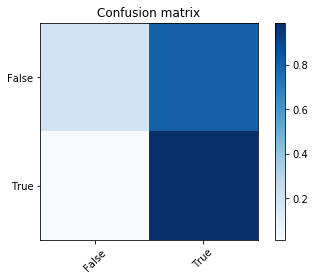

In [64]:
#classes correspond to 0,1
classes = ['False','True']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    
plot_confusion_matrix(confusion,classes, normalize=True)

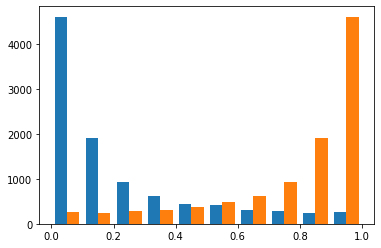

In [65]:
plt.hist(grid.predict_proba(X));

In [66]:
predicted_probabilities = grid.predict_proba(X)[:100]

In [67]:
probabilties = [p[1] for p in predicted_probabilities]

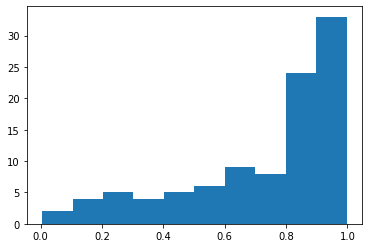

In [68]:
plt.hist(probabilties);

In [69]:
import pickle
s = pickle.dumps(grid)
new_grid = pickle.loads(s)
new_grid.predict(["I hate this product and everyone that eats this crap"])

array([0])

In [71]:
from sklearn.externals import joblib
joblib.dump(grid, '../flask_app_test/grid.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '../flask_app_test/grid.pkl'

Other things to try:

>The latent dirichlet idea for engineering features
>More features like the helpfulness rating of the review writer



In [ ]:
#run with 100000 cases Monday night. 
df_5 = text_cleaner(df_5, 'text_all')
X= df_5.text_all_cleaned.values
y= df_5.positive.values



from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

estimators = [('tfidf', TfidfVectorizer()), 
              ('reduce_dim', TruncatedSVD()), 
              ('clf', SVC(probability=True))]
pipe = Pipeline(estimators)

param_distributions = dict(tfidf__max_df=[0.1,0.2,0.5,0.8], 
                  #tfidf__min_df=[0.01, 0.02, 0.03 ], 
                  #tfidf__max_features=[10,50,100], Maybe do this with numbers over 100? 
                  tfidf__ngram_range=[(1,2),(1,3)],
                  reduce_dim__n_components=[2,5,10,20,50],
                  clf__C=[0.001, 1, 1000, 10000], 
                  clf__gamma=[0.1, 0.0001])

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=cv, scoring='neg_log_loss', n_jobs=-1)
grid.fit(X, y)
predictions = grid.predict(X)

print("The best parameters are {} with a log loss of {}".format(grid.best_params_, -1*grid.best_score_))
print('the accuracy of the model with 10^5 is {}'.format(accuracy_score(y, predictions)))

100000


In [ ]:
Best_Model = grid

Some last minute attempts. First, lay out the baseline MNB, LR, and SVM models.

Add new model: Random Forest? That is a last priority.

First, run the final version of the model.

In [ ]:
'''
Best Model tested on Larger Data Set, n = 100000
DATA PREP:
    TfidfVectorizer: ngram_range=(1,3); max_df=0.5
    TruncatedSVD: n_components=20
MODEL: 
    gamma=0.0001
    C=1000
RESULTS:
    log loss: 0.4301
    Accuracy: 0.7826
The best parameters are {'tfidf__ngram_range': (1, 3), 'tfidf__max_df': 0.5,
'reduce_dim__n_components': 20, 'clf__gamma': 0.0001, 'clf__C': 1000} with 
a log loss of 0.4301149914560899; the accuracy of the model 
with 10^5 is 0.78263.'''


### run the final form of the model
# X = df_3.text_all.values
# y = df_3.positive.values

# X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

# tfidf_vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)
# X_train_tfidf = tfidf_vec.fit_transform(X_train)
# X_test_tfidf = tfidf_vec.transform(X_test)

# svd = TruncatedSVD(n_components=20)
# X_train_tfidf_svd =svd.fit_transform(X_train_tfidf)
# X_test_tfidf_svd =svd.fit_transform(X_test_tfidf)


# svc = SVC(probability=True, C=1000,gamma=0.0001)
# svc.fit(X_train_tfidf_svd,y_train)
# predictions = svc.predict(X_test_tfidf_svd)
# accuracy_score(y_test, predictions)

#run on all data for the app
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)
X_t = tfidf_vec.fit_transform(X)

svd = TruncatedSVD(n_components=20)
X_t_s = svd.fit_transform(X_t)
print(X_t_s.shape)

print(type(X_t_s))
# np.save()

### Grid Search for final model
# estimators = [('tfidf', TfidfVectorizer()), 
#               ('reduce_dim', TruncatedSVD()), 
#               ('clf', SVC(probability=True))]
# pipe = Pipeline(estimators)

# param_distributions = dict(tfidf__max_df=[0.1,0.2,0.5,0.8], 
#                   #tfidf__min_df=[0.01, 0.02, 0.03 ], 
#                   #tfidf__max_features=[10,50,100], Maybe do this with numbers over 100? 
#                   tfidf__ngram_range=[(1,2),(1,3)],
#                   reduce_dim__n_components=[2,5,10,20,50],
#                   clf__C=[0.001, 1, 1000, 10000], 
#                   clf__gamma=[0.1, 0.0001])

# cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
# grid = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=cv, scoring='neg_log_loss', n_jobs=-1)
# grid.fit(X, y)
# predictions = grid.predict(X)

# print("The best parameters are {} with a log loss of {}".format(grid.best_params_, -1*grid.best_score_))
# print('the accuracy of the model with 10^5 is {}'.format(accuracy_score(y, predictions)))

In [ ]:
#save numpy array

In [22]:
#this is a working model for testing theories
# import timeit
# %%timeit

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

X= df_3.text_all_cleaned.values
y= df_3.positive.values



estimators = [('tfidf', TfidfVectorizer()), 
              ('reduce_dim', TruncatedSVD()), 
              ('clf', SVC(probability=True))]
pipe = Pipeline(estimators)

param_distributions = dict(tfidf__max_df=[0.05, 0.1,0.2,0.5,0.8], 
#                   tfidf__min_df=[0.01, 0.02, 0.03 ], 
                  tfidf__max_features=[200,300,400], #Maybe do this with numbers over 100? 
                  tfidf__ngram_range=[(1,2),(1,3)],
                  reduce_dim__n_components=[20,50,80,100,120,130,140,150],
                  clf__C=[1, 100, 1000, 10000], 
                  clf__gamma=[0.1, 0.0001, 0.00001, 0.000001])

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=cv, scoring='neg_log_loss',n_iter=25, n_jobs=-1)
grid.fit(X, y)
predictions = grid.predict(X)

print("The best parameters are {} with a log loss of {}".format(grid.best_params_, -1*grid.best_score_))

The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 400, 'tfidf__max_df': 0.5, 'reduce_dim__n_components': 150, 'clf__gamma': 1e-06, 'clf__C': 100} with a log loss of 0.3818472562554885


In [113]:
#this is a working model for testing theories
# import timeit
# %%timeit

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

# df_4 = importdf_sample_magnitude(4,42)
df_3 = importdf_sample_magnitude(3, 42)


df_3 = text_cleaner(df_3, 'text_all')

print(df_3.text_all_cleaned.values[:10])
print(df_3.text_all[:10])

1000
['Crunchy Good Gluten Free Sandwich Cookies have try couple brand gluten free sandwich cookie good bunch   crunchy true texture real cookie gluten free   think filling make bit sweet mean satisfy sweet tooth sooner   chocolate version Glutino good true chocolatey taste gluten free brand'
 'great kitty treat cat love treat find house pop bolt hide come treat like crunchy treat perfect give flavor like equally tend dry time near end bottle flip lid handy nice inexpensive kitty treat meet cat love'
 'COFFEE taste little expect   tend muddy taste expect say favorite company'
 'Mini Wheats big frost Mini Wheats original size frost Mini Wheats Bite Size reason mouthful frost Mini wheat Little Bits yes half size Bite Size version particular Cinnamon roll".there new table exception size unnecessary personally like original flavor size good Bite Size edition accommodate come desperate attempt attention brand need sort life come make small have new flavor actually sweet serve size approxima

In [121]:
X = df_3.text_all_cleaned.values
y = df_3.positive.values



estimators = [('tfidf', TfidfVectorizer(max_df=0.5, max_features=400, ngram_range=(1,3))), 
              ('reduce_dim', TruncatedSVD(n_components=150)), 
              ('clf', SVC(probability=True, C=100, gamma=0.000001))]

pipe = Pipeline(estimators)


# cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
# grid = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=cv, scoring='neg_log_loss',n_iter=25, n_jobs=-1)


pipe.fit(X, y)
predictions = pipe.predict(X)

print(f"The best parameters are {grid.best_params_} with a log loss of {-1*grid.best_score_}")




The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 400, 'tfidf__max_df': 0.5, 'reduce_dim__n_components': 150, 'clf__gamma': 1e-06, 'clf__C': 100} with a log loss of 0.3818472562554885


In [127]:
one_case_pred = pipe.predict(['crunchy good gluten free sandwich cookie have try couple brand gluten free sandwich cookie good bunch   crunchy true texture real cookie gluten free   think filling make bit sweet mean satisfy sweet tooth sooner   chocolate version glutino good true chocolatey taste gluten free brand'])
one_case_pred[0]            
             

1

In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, predictions)/1000

array([[0.  , 0.22],
       [0.  , 0.78]])

In [ ]:
'tfidf', TfidfVectorizer()